In [113]:
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from tqdm import tqdm
import pymorphy2
import string

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Таблица с исходными и исправленными запросами

- orig - исходный запрос
- new - исправленный запрос
- deleted - удаленные из исходного запроса слова
- added - добавленные в исходный запрос слова

In [3]:
queries_df = pd.read_csv('queries_fixed.csv', usecols=['нулевой запрос', 'успешный запрос', 'что выкинули', 'что добавили'])
queries_df.columns = ['old', 'new', 'deleted', 'added']
queries_df = queries_df[(queries_df['old'] == queries_df['old']) & (queries_df['new'] == queries_df['new'])]
print(queries_df.shape)
queries_df['old'] = queries_df['old'].apply(lambda sent: sent.strip())
queries_df['new'] = queries_df['new'].apply(lambda sent: sent.strip())
queries_df.tail()

(4410, 4)


,old,new,deleted,added
4412,является ли нарушением законодательства несоот...,является ли нарушением законодательства несоот...,его на и выполнение создания в пл отраженными,NaN
4413,является ли несовместное проживание с детьми п...,имеет ли право требовать пенсионный фонд при н...,отказа детьми поводом с в проживание является ...,назначении фонд имеет совместном право прожива...
4414,является ли объектами налогообложения налогом ...,пожарная сигнализация налог на имущество в 2019,и объектами видеонаблюдения ли система являетс...,налог
4415,является ли основанием для увольнения руководи...,типовая форма договора с руководителем федерал...,указанием увольнения задолженности ли автономн...,форма руководителем договора типовая
4416,#ERROR!,- ткань должна соответствовать требованиям ГОС...,NaN,ГОСТ 29298-2005 Ткани хлопчатобумажные и смеша...


#### Нормализуем запросы

- norm_old
- norm_new

In [5]:
morph = pymorphy2.MorphAnalyzer()

In [34]:
all_norm_old = []
all_norm_new = []

for row in tqdm(queries_df.itertuples(), total=queries_df.shape[0]):
    norm_old = ''
    row_old = row.old.translate(str.maketrans('', '', string.punctuation))
    for word in row_old.split():
        norm_old += morph.parse(word)[0].normal_form + ' '
    norm_old = norm_old[:-1]
    all_norm_old.append(norm_old)
        
    norm_new = ''
    row_new = row.new.translate(str.maketrans('', '', string.punctuation))
    for word in row_new.split():
        norm_new += morph.parse(word)[0].normal_form + ' '
    norm_new = norm_new[:-1]
    all_norm_new.append(norm_new)

queries_df['norm_old'] = all_norm_old
queries_df['norm_new'] = all_norm_new

queries_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 4410/4410 [00:23<00:00, 183.87it/s]


,old,new,deleted,added,norm_old,norm_new
0,Постановление Правительства РМ16.02.2008 г № 7,Постановление Правительства РМ от 16.02.200...,РМ16.02.2008,16.02.2008 РМ от,постановление правительство рм16022008 год № 7,постановление правительство рм от 16022008 год...
1,"Действующие тарифы на перевозку пассажиров, ру...","на перевозку пассажиров, ручной клади и живности",тарифы Действующие,NaN,действующий тариф на перевозка пассажир ручной...,на перевозка пассажир ручной класть и живность
2,постановление о мерах социальной поддержки...,постановление о мерах социальной поддержки...,удмуртия,NaN,постановление о мера социальный поддержка рабо...,постановление о мера социальный поддержка рабо...
3,практические рекомендации по организации внут...,практические рекомендации по организации внут...,стоматология,NaN,практический рекомендация по организация внутр...,практический рекомендация по организация внутр...
4,РЕШЕНИЕ от 1 августа 2018 г. N 223ФЗ-556/18,N 18/44/105/918,РЕШЕНИЕ августа от 223ФЗ-556/18 2018 г. 1,18/44/105/918,решение от 1 август 2018 год n 223фз55618,n 1844105918


In [35]:
all_normforms = all_norm_old
all_normforms.extend(all_norm_new)
len(all_normforms), all_normforms[:10]

(8820,
 ['постановление правительство рм16022008 год № 7',
  'действующий тариф на перевозка пассажир ручной класть и живность',
  'постановление о мера социальный поддержка работник муниципальный учреждение удмуртия',
  'практический рекомендация по организация внутренний контроль качество и безопасность медицинский деятельность в медицинский организация стоматология',
  'решение от 1 август 2018 год n 223фз55618',
  'о внесение изменение в постановление глава администрация губернатор краснодарский край от 20 январь 2017 год № 48 о утверждение порядок сбор в тот число раздельный твёрдый коммунальный отход в краснодарский край',
  '04052011 n 99фp',
  '1151006 налоговый декларация по налог на прибыль за 2019 по место учёт учреждение оказывать социальный услуга',
  '17 декабря№382 о внесение изменение',
  '19032012 n 161523501 о порядок заполнение граф 4 счетафактура'])

### TF IDF

In [36]:
cv = CountVectorizer(min_df=2)
word_count_vector = cv.fit_transform(all_normforms)
word_count_vector.shape

(8820, 5510)

In [37]:
word_count_vector1 = word_count_vector.copy()
for i in range(73):
    if i == 0:
        word_freq_array = word_count_vector1[:10000].toarray().sum(axis=0)
    else:
        word_freq_array = np.vstack((word_freq_array,word_count_vector1[:10000].toarray().sum(axis=0)))
    word_count_vector1 = word_count_vector1[10000:]
all_word_freq = word_freq_array.sum(axis=0)
len(all_word_freq)

5510

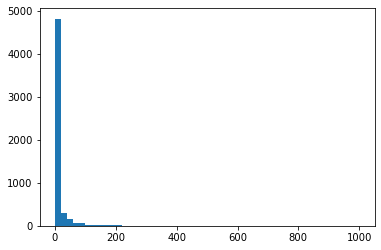

In [38]:
#распределение частот слов
_=plt.hist(list(all_word_freq),range=[0,1000],bins=50)

In [39]:
words = cv.get_feature_names()
len(words)

5510

In [40]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(word_count_vector)

all_normforms_transformed = cv.transform(all_normforms)
all_normforms_tfidf = tfidf_transformer.transform(all_normforms_transformed)

In [41]:
tfidf_transformer.idf_.shape

(5510,)

In [42]:
all_normforms_tfidf.shape

(8820, 5510)

### word2vec


In [43]:
sent_split = [nf.split() for nf in all_normforms]
phrases = Phrases(sent_split, min_count=30)
bigram = Phraser(phrases)
sentences = bigram[sent_split]

In [44]:
w2v = Word2Vec(min_count=20, # Ignores all words with total absolute frequency lower than this
                     window=2,     # The maximum distance between the current and predicted word within a sentence.
                     size=300,     # Dimensionality of the feature vectors.
                     sample=6e-5,  # The threshold for configuring which higher-frequency words are randomly downsampled.
                                   # Highly influencial.
                     alpha=0.03,   # The initial learning rate
                     min_alpha=0.0007, 
                     negative=20) # If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown.
                                  # If set to 0, no negative sampling is used.

In [45]:
w2v.build_vocab(sentences)

In [46]:
w2v.train(sentences, total_examples=w2v.corpus_count, # total_examples - Count of sentences
                epochs=30, report_delay=1)

(434143, 2720130)

In [47]:
# make the model more memory-efficient
w2v.init_sims(replace=True)

In [48]:
len(w2v.wv.vocab.items())

755

In [66]:
w2v.wv.most_similar(positive='кодекс')

[('статья', 0.9997572302818298),
 ('пункт', 0.9997450113296509),
 ('наш', 0.9996573328971863),
 ('том', 0.9996564984321594),
 ('фз', 0.9996451139450073),
 ('ссср', 0.9996143579483032),
 ('направление', 0.9996132850646973),
 ('гражданский', 0.9996116161346436),
 ('гк', 0.9996071457862854),
 ('редакция', 0.9996019005775452)]

In [50]:
index2word_set = set(w2v.wv.index2word)

# for sentences
def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [51]:
def sentence_similarity(sent1, sent2):
    s1_afv = avg_feature_vector(sent1, model=w2v, num_features=300, index2word_set=index2word_set)
    s2_afv = avg_feature_vector(sent2, model=w2v, num_features=300, index2word_set=index2word_set)
    sim = 1 - spatial.distance.cosine(s1_afv, s2_afv)
    return sim

In [54]:
sentence_similarity('постановление правительство рм16.02.2008 год № 7',
                    'постановление правительство рм16.02.2008')

0.9959808588027954

In [55]:
sentence_similarity('постановление правительство рм16.02.2008 год № 7',
                    'постановление о мера социальный поддержка работник муниципальный учреждение удмуртия')

0.9815549850463867

In [59]:
sentence_similarity('постановление правительство рм16.02.2008 год № 7',
                    'действующий тариф на перевозка пассажир ручной класть и живность')

0.9677363634109497

### final data table

In [67]:
feature_names = cv.get_feature_names()
'постановление' in feature_names

True

In [68]:
idf_df = pd.DataFrame(tfidf_transformer.idf_, index=feature_names, columns=["idf"])
idf_df.tail()

,idf
янао,8.005449
январь,5.531014
ярмарка,8.698596
ярославский,7.519941
ёлка,8.986278


In [108]:
word_features_table = []
row_names_list = []
Y = []

for it, q_row in tqdm(queries_df.iterrows(), total=queries_df.shape[0]):
    old = q_row.old
    new = q_row.new
    deleted = [word for word in old.split() if word not in new.split()]
    
    tfidf_row = pd.DataFrame(all_normforms_tfidf[it].T.todense(), index=feature_names, columns=["tfidf"])
    #print(tfidf_row)
    
    for word in old.split():
        if word.lower() in feature_names:
            row_names_list.append(word+'_'+str(it)+'_'+old) # row name
            
            Y.append(1 if word in deleted else 0) # Y
            
            features_row = []
            features_row.append(tfidf_row.loc[word.lower()].tolist()[0]) # tfidf
            features_row.append(idf_df.loc[word.lower()].tolist()[0]) # idf
            features_row.append(sentence_similarity(old, old.replace(word, '').replace('  ', ' '))) # w2v_imp
        
            word_features_table.append(features_row)
    
word_features_df = pd.DataFrame(word_features_table, index=row_names_list,
                                columns=['tfidf', 'idf', 'w2v_imp']).fillna(0)
print(word_features_df.shape)
word_features_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 4410/4410 [00:17<00:00, 251.68it/s]

(15839, 3)


,tfidf,idf,w2v_imp
Постановление_0_Постановление Правительства РМ16.02.2008 г № 7,0.561594,3.385390,1.000000
"на_1_Действующие тарифы на перевозку пассажиров, ручной клади и живности",0.144178,3.014166,0.995725
"ручной_1_Действующие тарифы на перевозку пассажиров, ручной клади и живности",0.429845,8.986278,1.000000
постановление_2_постановление о мерах социальной поддержки работников муниципальных учреждений удмуртия,0.250312,3.385390,0.995361
по_3_практические рекомендации по организации внутреннего контроля качества и безопасности медицинской деятельности в медицинской организации стоматология,0.129407,2.979104,0.999954


In [179]:
X_train, X_test, y_train, y_test = train_test_split(word_features_df, Y, test_size=0.1, random_state=15)

X_train.shape, X_test.shape, len(y_train), len(y_test)

((14255, 3), (1584, 3), 14255, 1584)

In [180]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [181]:
y_pred = rf.predict(X_test)

In [182]:
confusion_matrix(y_test, y_pred)

array([[536, 300],
       [362, 386]], dtype=int64)

In [167]:
result_dict = {}
for query in X_test.index:
    splitted = query.split('_')
    word = splitted[0]
    N = splitted[1]
    sent = ''
    for part in splitted[2:]:
        sent += part
        
    N = int(N)
    if N not in result_dict.keys():
        result_dict[N] = {'query':sent, 'del':[word]}
    else:
        result_dict[N]['del'].append(word)

In [174]:
result_dict

{4196: {'query': 'уточнить по строке 121 в приложении 5 листа 02 размер авансовых платежей на 1 квартал следующего года',
  'del': ['на', '121', '02'],
  'new': 'уточнить по строке в приложении 5 листа размер авансовых платежей 1 квартал следующего года'},
 2013: {'query': 'ОПРЕДЕЛЕНИЕ СУДЕБНОЙ КОЛЛЕГИИ ПО ЭКОНОМИЧЕСКИМ СПОРАМ ВЕРХОВНОГО СУДА РФ № 302-ЭС16-14360 ПО ДЕЛУ N А33-28174/2015 ОТ 9 МАРТА 2017 Г. Материал взят с сайта https://razvitie.expert/npa/36232',
  'del': ['ОТ', 'ПО'],
  'new': 'ОПРЕДЕЛЕНИЕ СУДЕБНОЙ КОЛЛЕГИИ ЭКОНОМИЧЕСКИМ СПОРАМ ВЕРХОВНОГО СУДА РФ № 302-ЭС16-14360 ДЕЛУ N А33-28174/2015 9 МАРТА 2017 Г. Материал взят с сайта https://razvitie.expert/npa/36232'},
 3786: {'query': 'сколько дней можно оплатить по больничному листу с кодами 02 и01',
  'del': ['02', 'оплатить'],
  'new': 'сколько дней можно по больничному листу с кодами и01'},
 588: {'query': 'внесение изменений в решение комитета по управлению муниципальным имуществом о выделе многодетной семье земельного учас

In [172]:
for N in result_dict.keys():
    new = [word for word in result_dict[N]['query'].split() if word not in result_dict[N]['del']]
    new_str = ''
    for word in new:
        new_str += word + ' '
    new_str = new_str[:-1]
    result_dict[N]['new'] = new_str

In [173]:
for N in result_dict.keys():
    print(result_dict[N]['query'],'\n',  result_dict[N]['new'], '\n\n')

уточнить по строке 121 в приложении 5 листа 02 размер авансовых платежей на 1 квартал следующего года 
 уточнить по строке в приложении 5 листа размер авансовых платежей 1 квартал следующего года 


ОПРЕДЕЛЕНИЕ СУДЕБНОЙ КОЛЛЕГИИ ПО ЭКОНОМИЧЕСКИМ СПОРАМ ВЕРХОВНОГО СУДА РФ № 302-ЭС16-14360 ПО ДЕЛУ N А33-28174/2015 ОТ 9 МАРТА 2017 Г. Материал взят с сайта https://razvitie.expert/npa/36232 
 ОПРЕДЕЛЕНИЕ СУДЕБНОЙ КОЛЛЕГИИ ЭКОНОМИЧЕСКИМ СПОРАМ ВЕРХОВНОГО СУДА РФ № 302-ЭС16-14360 ДЕЛУ N А33-28174/2015 9 МАРТА 2017 Г. Материал взят с сайта https://razvitie.expert/npa/36232 


сколько дней можно оплатить по больничному листу с кодами 02 и01 
 сколько дней можно по больничному листу с кодами и01 


внесение изменений в решение комитета по управлению муниципальным имуществом о выделе многодетной семье земельного участка в долевую собственность умершему ребенку 
 изменений в решение комитета по управлению муниципальным имуществом о выделе многодетной семье земельного участка в долевую собственност

 САНИТАРНЫЕ ПРАВИЛА при работе со смазочно-охлаждающими жидкостями и технологическими смазками УТВЕРЖДЕНЫ Заместителем главного государственного санитарного врача А.И.Заиченко сентября 1985 г., N 3935-85 


Постановление Кабинета министров Республики Адыгея № 200 о прогнозировании потребности в кадрах 
 Кабинета министров Республики Адыгея № о прогнозировании потребности в кадрах 


образец заполнения  ф 0503128 за 2019 год 
 образец заполнения ф 0503128 за год 


Внешняя проверка годовой бюджетной отчетности главных администраторов включает в себя комплекс аудиторских проверок годовой бюджетной отчетности 
 Внешняя проверка бюджетной отчетности главных администраторов включает в себя аудиторских проверок бюджетной отчетности 


совет министров рсфср постановляет утвердить согласованный с госстроем ссср и вцспс прилагаемый перечень отдельных ведущих профессий по которым молодым рабочим окончившим общеобразовательные школы с производственным обучением краткосрочные курсы или прошедшим и

 счету 40110155 допустим квфо 2 код аналитики 


Постановление правительства № 294н "Об особенностях финансового обеспечения, назначения и выплаты 
 правительства № 294н "Об особенностях финансового обеспечения, назначения и выплаты 


взыскание коммунальных услуг с собственника не проживает 
 коммунальных услуг с собственника не проживает 


где в форме 0503737 встанет возврат остатков целевых субсидий 
 в форме 0503737 встанет остатков целевых субсидий 


срок j fkjdfybz jghtltktybz суда заявление о признании должника банкротом 
 срок j fkjdfybz jghtltktybz суда о признании должника банкротом 


Постановление РСТ ПК от 20.12.2018 № 365-т 
 Постановление РСТ ПК 20.12.2018 № 365-т 


размещение bcgjkytybz в tbc по 223-фз 
 bcgjkytybz в tbc по 223-фз 


оплата багажа относится ли к комрасходам 
 оплата багажа относится к комрасходам 


как списать бензин в бюджетном учреждении если поездки совершаются на личном транспорте 
 бензин в бюджетном учреждении если поездки совершаются на лично